In [2]:
import matplotlib.pyplot as plt
import fenics as fe
import mshr
import numpy as np
from scipy.linalg import eig
import sympy as sp
import plotly.graph_objects as go
from scipy.interpolate import griddata

In [3]:
# Constants
CENTER = fe.Point(0, 0)
RADIUS = 1
DOMAIN = mshr.Circle(CENTER, RADIUS)
RHS_F = fe.Constant(1)
DIRICHLET_BC = fe.Constant(0)

MESH_RESOLUTION_RANDOM_FIELD_CALCULATION = 4


# Define covariance functions
def v_cov1_1 (x, y):
    return 5.0/100.0 * sp.exp(-4.0 * ((x[0] - y[0])**2 + (x[1] - y[1])**2))
def v_cov1_2 (x, y):
    return 1.0/100.0 * sp.exp(-0.1 * ((2*x[0] - y[0])**2 + (2*x[1] - y[1])**2))
def v_cov2_1 (x, y):
    return 1.0/100.0 * sp.exp(-0.1 * ((x[0] - 2*y[0])**2 + (x[1] - 2*y[1])**2))
def v_cov2_2 (x, y):
    return 5.0/100.0 * sp.exp(-1.0 * ((x[0] - y[0])**2 + (x[1] - y[1])**2))


In [63]:
# Understand differentiable basis functions
mesh = mshr.generate_mesh(DOMAIN, 2)
V = fe.FunctionSpace(mesh, "P", 3)
#! V = fe.FunctionSpace(mesh, "HER", 3) not supported
basis_function = fe.Function(V)
basis_function.vector()[2] = 1

def plot_basis_function(f):
    x_coords = mesh.coordinates()[:, 0]
    y_coords = mesh.coordinates()[:, 1]
    z_values = []
    for i in range(len(x_coords)):
        z_values.append(f(x_coords[i], y_coords[i]))
    grid_x, grid_y = np.mgrid[-1:1:500j, -1:1:500j]  # Increased resolution
    grid_z = griddata((x_coords, y_coords), z_values, (grid_x, grid_y), method='cubic')
    fig = go.Figure(data=[go.Surface(z=grid_z, x=grid_x, y=grid_y, colorscale='Viridis')])
    fig.update_layout(title='Basis Function', autosize=True,
                    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='u(x, y)'),
                    margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

plot_basis_function(basis_function)

Calling FFC just-in-time (JIT) compiler, this may take some time.
This element family (Hermite) is not supported by FFC.


Exception: This element family (Hermite) is not supported by FFC.

In [5]:
def find_affine_transformation(triangle):
    transformation_matrix = np.array([[triangle[1, 0] - triangle[0, 0], triangle[2, 0] - triangle[0, 0]],
                                    [triangle[1, 1] - triangle[0, 1], triangle[2, 1] - triangle[0, 1]]])
    transformation_vector = np.array([triangle[0, 0], triangle[0, 1]])
    return transformation_matrix, transformation_vector

class quad_point():
    def __init__(self, point: list, weight: float):
        self.point = point
        self.weight = weight

QUAD_POINTS_2DD_5 = [quad_point([0, 0], 3/120),
                        quad_point([1, 0], 3/120),
                        quad_point([0, 1], 3/120),
                        quad_point([1/2, 0], 8/120),
                        quad_point([1/2, 1/2], 8/120),
                        quad_point([0, 1/2], 8/120),
                        quad_point([1/3, 1/3], 27/120)]
QUAD_POINTS_2DD_6 = [quad_point([(6 - np.sqrt(15)) / 21, (6 - np.sqrt(15)) / 21], (155 - np.sqrt(15)) / 2400),
                        quad_point([(9 + 2 * np.sqrt(15)) / 21, (6 - np.sqrt(15)) / 21], (155 - np.sqrt(15)) / 2400),
                        quad_point([(6 - np.sqrt(15)) / 21, (9 + 2 * np.sqrt(15)) / 21], (155 - np.sqrt(15)) / 2400),
                        quad_point([(6 + np.sqrt(15)) / 21, (9 - 2 * np.sqrt(15)) / 21], (155 + np.sqrt(15)) / 2400),
                        quad_point([(6 + np.sqrt(15)) / 21, (6 + np.sqrt(15)) / 21], (155 + np.sqrt(15)) / 2400),
                        quad_point([(9 - 2 * np.sqrt(15)) / 21, (6 + np.sqrt(15)) / 21], (155 + np.sqrt(15)) / 2400),
                        quad_point([1 / 3, 1 / 3], 9/80)]

def triangle_area(vertices):
    x1, y1 = vertices[0]
    x2, y2 = vertices[1]
    x3, y3 = vertices[2]
    # which is the determinant of the transformation matrix
    return 0.5 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))


class BasisFunction():
    def __init__(self, basis_function: fe.Function, supp_cells: list):
        self.function = basis_function
        self.supp_cells = supp_cells

class RandomFieldV():
    def __init__(self, eigenvalues, eigenvectors, basis_functions, N, J):
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.basis_functions = basis_functions
        self.N = N
        self.J = J

    def __call__(self, x, xi):
        return x[0] + sum([np.sqrt(self.eigenvalues[j]) * sum([self.eigenvectors[k, j] * self.basis_functions[k].function(x) for k in range(self.N)]) * xi[j] for j in range(len(xi))]), \
           x[1] + sum([np.sqrt(self.eigenvalues[j]) * sum([self.eigenvectors[self.N + k, j] * self.basis_functions[k].function(x) for k in range(self.N)]) * xi[j] for j in range(len(xi))])

class JacobianV():
    def __init__(self, eigenvalues, eigenvectors, basis_functions_grads, N: int, J: int):
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.basis_functions_grads = basis_functions_grads
        self.N = N
        self.J = J

    def __call__(self, x, xi):
        jacobian_output = np.zeros((2, 2))
        jacobian_output[0, 0] = 1 + sum([np.sqrt(self.eigenvalues[j]) * sum([self.eigenvectors[k, j] * self.basis_functions_grads[k].function(x)[0] for k in range(self.N)]) * xi[j] for j in range(len(xi))])
        jacobian_output[0, 1] = sum([np.sqrt(self.eigenvalues[j]) * sum([self.eigenvectors[self.N + k, j] * self.basis_functions_grads[k].function(x)[0] for k in range(self.N)]) * xi[j] for j in range(len(xi))])
        jacobian_output[1, 0] = sum([np.sqrt(self.eigenvalues[j]) * sum([self.eigenvectors[k, j] * self.basis_functions_grads[k].function(x)[1] for k in range(self.N)]) * xi[j] for j in range(len(xi))])
        jacobian_output[1, 1] = 1 + sum([np.sqrt(self.eigenvalues[j]) * sum([self.eigenvectors[self.N + k, j] * self.basis_functions_grads[k].function(x)[0] for k in range(self.N)]) * xi[j] for j in range(len(xi))])
        return jacobian_output
    

class AExpression(fe.UserExpression):
    def __init__(self, jacobianV, xi, **kwargs):
        super().__init__(**kwargs)
        self.jacobianV = jacobianV
        self.xi = xi

    def eval(self, values, x):
        J_x = self.jacobianV(x, self.xi)
        inv_JTJ = np.linalg.inv(J_x.T @ J_x)
        det_J = np.linalg.det(J_x)
        A_x = inv_JTJ * det_J
        values[0] = A_x[0, 0]
        values[1] = A_x[0, 1]
        values[2] = A_x[1, 0]
        values[3] = A_x[1, 1]

    def value_shape(self):
        return (2, 2)

class detJExpression(fe.UserExpression):
    def __init__(self, jacobianV, xi, **kwargs):
        super().__init__(**kwargs)
        self.jacobianV = jacobianV
        self.xi = xi

    def eval(self, values, x):
        J_x = self.jacobianV(x, self.xi)
        det_J = np.linalg.det(J_x)
        values[0] = det_J

    def value_shape(self):
        return ()

class RandomFieldExpression(fe.UserExpression):
    def __init__(self, randomfieldV, xi, **kwargs):
        super().__init__(**kwargs)
        self.randomfieldV = randomfieldV
        self.xi = xi

    def eval(self, values, x):
        values[0] = self.randomfieldV(x, self.xi)
    
    def value_shape(self):
        return ()


def get_C_entry(f, basis_function_i: BasisFunction, basis_function_j: BasisFunction):

    active_quad_points = QUAD_POINTS_2DD_6

    integral = 0

    for cell_x in basis_function_i.supp_cells:
        transformation_matrix_x, transformation_vector_x = find_affine_transformation(np.array(cell_x.get_vertex_coordinates()).reshape((-1, 2)))
        area_x = triangle_area(np.array(cell_x.get_vertex_coordinates()).reshape((-1, 2)))
        quad_points_x = [quad_point(np.dot(transformation_matrix_x, quad_point_x.point) + transformation_vector_x, quad_point_x.weight * 2 * area_x) for quad_point_x in active_quad_points]

        for cell_y in basis_function_j.supp_cells:
            transformation_matrix_y, transformation_vector_y = find_affine_transformation(np.array(cell_y.get_vertex_coordinates()).reshape((-1, 2)))
            area_y = triangle_area(np.array(cell_y.get_vertex_coordinates()).reshape((-1, 2)))
            quad_points_y = [quad_point(np.dot(transformation_matrix_y, quad_point_y.point) + transformation_vector_y, quad_point_y.weight * 2 * area_y) for quad_point_y in active_quad_points]

            for quad_point_x in quad_points_x:
                for quad_point_y in quad_points_y:
                    integral += f(quad_point_x.point, quad_point_y.point) * basis_function_i.function(quad_point_x.point) * basis_function_j.function(quad_point_y.point) * quad_point_x.weight * quad_point_y.weight
    return integral

def calculate_vector_field_eigenpairs(mesh_resolution):  
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution)
    V = fe.FunctionSpace(mesh, "P", 3)
    V_Vector = fe.VectorFunctionSpace(mesh, "P", 3)
    
    basis_functions = []
    basis_functions_grads = []

    for i in range(V.dim()):
        basis_function = fe.Function(V)
        basis_function.vector()[i] = 1
        for vertex in fe.vertices(mesh):
            if abs(basis_function(vertex.point().array()[:2]) - 1) < 1e-6:
                basis_function.set_allow_extrapolation(True)
                grad = fe.project(fe.grad(basis_function), V_Vector)
                grad.set_allow_extrapolation(True)
                supp_cells = [cell for cell in fe.cells(mesh) if basis_function(cell.midpoint().array()[:2]) != 0]
                basis_functions.append(BasisFunction(basis_function, supp_cells))
                basis_functions_grads.append(BasisFunction(grad, supp_cells))
    
    N = len(basis_functions)

    C = np.zeros((2 * N, 2 * N))
    for i, basis_function_i in enumerate(basis_functions):
        for j, basis_function_j in enumerate(basis_functions):
            if j <= i:
                # Here we use that each block is symmetric because of the symmetry of the covariance functions
                C[i, j] = C[j, i] = get_C_entry(v_cov1_1, basis_function_i, basis_function_j)
                C[i, N + j] = C[j, N + i] = get_C_entry(v_cov1_2, basis_function_i, basis_function_j)
                C[N + i, j] = C[N + j, i] = get_C_entry(v_cov2_1, basis_function_i, basis_function_j)
                C[N + i, N + j] = C[N + j, N + i] = get_C_entry(v_cov2_2, basis_function_i, basis_function_j)

    M = np.zeros((2 * N, 2 * N))
    for i, basis_function_i in enumerate(basis_functions):
        for j, basis_function_j in enumerate(basis_functions):
            integrand = basis_function_i.function * basis_function_j.function * fe.dx
            M[i, j] = M[N + i, N + j] = fe.assemble(integrand)

    J = N # Number of eigenvectors -> J = N is maximum
    eigenvalues, eigenvectors = eig(C, M)
    eigenvalues = eigenvalues[:J].real
    eigenvectors = eigenvectors[:, :J].real
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Eliminate negative eigenvalues
    for index, sorted_eigenvalue in enumerate(sorted_eigenvalues):
        if sorted_eigenvalue < 0:
            sorted_eigenvalues[index] = 0
    return RandomFieldV(sorted_eigenvalues, sorted_eigenvectors, basis_functions, N, J), \
            JacobianV(sorted_eigenvalues, sorted_eigenvectors, basis_functions_grads, N, J)
    

In [6]:
randomFieldV, jacobianV = calculate_vector_field_eigenpairs(4)
# for MESH_RESOLUTION_RANDOM_FIELD_CALCULATION = 3 it takes approximately: 6 minutes
# for MESH_RESOLUTION_RANDOM_FIELD_CALCULATION = 4 it takes approximately: 22 minutes

In [7]:
# for basis_function in randomFieldV.basis_functions:
#     plot_basis_function(basis_function.function)

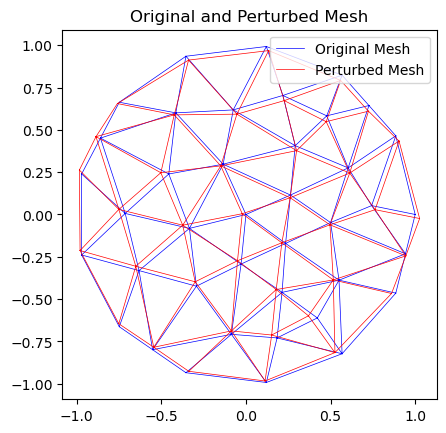

In [8]:
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), randomFieldV.J)
mesh = mshr.generate_mesh(DOMAIN, MESH_RESOLUTION_RANDOM_FIELD_CALCULATION)
# perturbed mesh based on the "original" mesh used for the KL-expansion
perturbed_coordinates = mesh.coordinates().copy()
for index, coordinate in enumerate(mesh.coordinates()):
    perturbed_coordinates[index] = randomFieldV(coordinate, xi)
# Create a new mesh with the perturbed coordinates
perturbed_mesh = fe.Mesh(mesh)
perturbed_mesh.coordinates()[:] = perturbed_coordinates

# Plot the original mesh and the perturbed mesh in one figure with different colors
plt.figure()
fe.plot(mesh, color='blue', linewidth=0.5, label='Original Mesh')
fe.plot(perturbed_mesh, color='red', linewidth=0.5, label='Perturbed Mesh')
plt.legend()
plt.title(f"Original and Perturbed Mesh")
plt.show()

In [9]:
def solve_poisson_for_given_sample(mesh_resolution, jacobianV, xi, f):
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution)
    V = fe.FunctionSpace(mesh, "CG", 3)
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    A_expr = AExpression(jacobianV, xi, degree=2)
    a = fe.inner(fe.dot(A_expr, fe.grad(u)), fe.grad(v)) * fe.dx
    det_J_expr = detJExpression(jacobianV, xi, degree=2)
    L = f * det_J_expr * v * fe.dx
    bc = fe.DirichletBC(V, DIRICHLET_BC, 'on_boundary')
    u_sol = fe.Function(V)
    fe.solve(a == L, u_sol, bc)
    return u_sol

randomFieldV.J: 40
Solving linear variational problem.
  Building point search tree to accelerate distance queries.
  Computed bounding box tree with 121 nodes for 61 points.


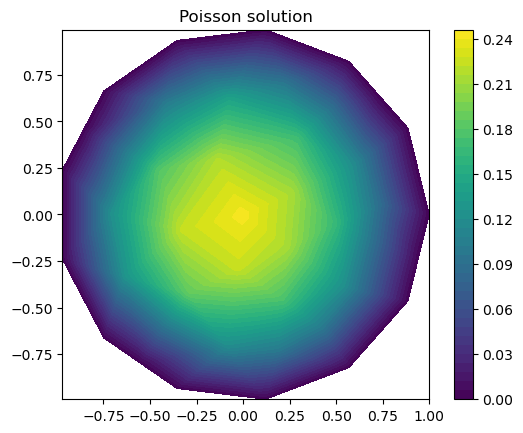

In [10]:
print(f"randomFieldV.J: {randomFieldV.J}")
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), 20)
# Ensure that len(xi) < randomFieldV.J

mesh_resolution_solution = 4
u_sol = solve_poisson_for_given_sample(mesh_resolution_solution, jacobianV, xi, RHS_F)
# len(xi) = 20 and mesh_resolution_solution = 4 lead to 1 minute 13 seconds

c = fe.plot(u_sol, title="Poisson solution")
plt.colorbar(c)
plt.show()

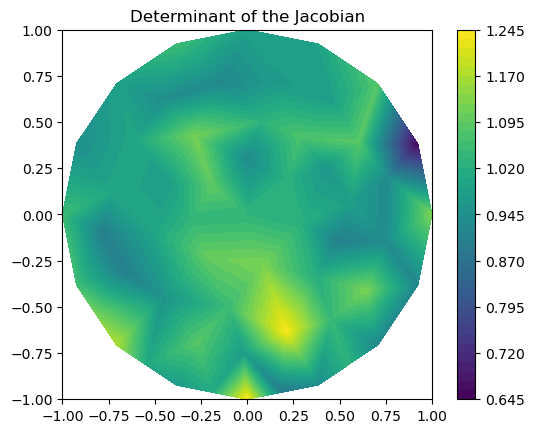

In [11]:
det_J_expr = detJExpression(jacobianV, xi, degree=2)
mesh = mshr.generate_mesh(DOMAIN, 5)
V = fe.FunctionSpace(mesh, "P", 1)
det_J_func = fe.project(det_J_expr, V)

c = fe.plot(det_J_func, title="Determinant of the Jacobian")
plt.colorbar(c)
plt.show()

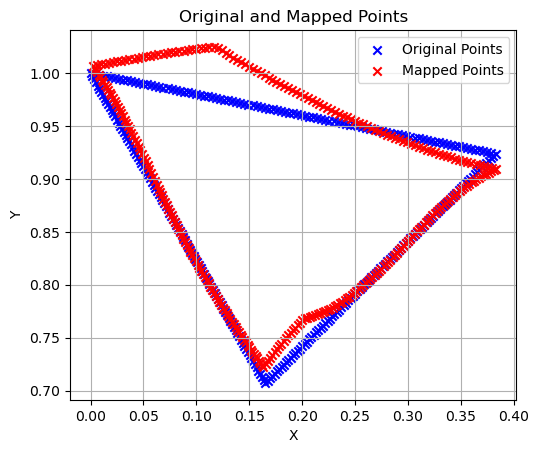

In [27]:
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), randomFieldV.J)

numer_of_points_per_edge = 100

orig_tri = next(fe.cells(mesh))
orig_tri_coords = np.array(orig_tri.get_vertex_coordinates()).reshape((-1, 2))
orig_points = []
for i in range(numer_of_points_per_edge):
    orig_points.append(i/numer_of_points_per_edge * orig_tri_coords[0] + (1 - i/numer_of_points_per_edge) * orig_tri_coords[1])
    orig_points.append(i/numer_of_points_per_edge * orig_tri_coords[1] + (1 - i/numer_of_points_per_edge) * orig_tri_coords[2])
    orig_points.append(i/numer_of_points_per_edge * orig_tri_coords[2] + (1 - i/numer_of_points_per_edge) * orig_tri_coords[0])

mapped_points = []
for orig_point in orig_points:
    mapped_points.append(randomFieldV(orig_point, xi))


orig_points = np.array(orig_points)
mapped_points = np.array(mapped_points)

plt.figure()

# Plot original triangle points
plt.scatter(orig_points[:, 0], orig_points[:, 1], color='blue', label='Original Points', marker='x')

# Plot mapped triangle points
plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='red', label='Mapped Points', marker='x')

plt.legend()
plt.title('Original and Mapped Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

image_bary_coords: [0.70278208 0.1167821  0.18043581]
image_tria_coords: [[-0.04110258  0.04609105]
 [ 0.06353868 -0.19566641]
 [ 0.17438875  0.00254036]]
original_tria_coords: [[ 0.00000000e+00 -5.55111512e-17]
 [ 6.40448694e-02 -1.95990097e-01]
 [ 1.75481890e-01  2.55958860e-03]]
New inner point in the original triangle: [ 0.03914251 -0.02242629]


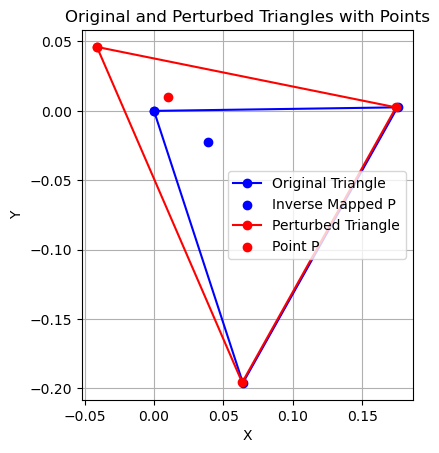

Solving linear variational problem.
inverse_mapped_P_solution: 0.2528652967196081


In [35]:
P = fe.Point(0.01, 0.01)

mesh_resolution_inverse_mapping = 8
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), randomFieldV.J)

mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_inverse_mapping)
# perturbed mesh based on the "original" mesh used for the KL-expansion
perturbed_coordinates = mesh.coordinates().copy()
for index, coordinate in enumerate(mesh.coordinates()):
    perturbed_coordinates[index] = randomFieldV(coordinate, xi)
# Create a new mesh with the perturbed coordinates
perturbed_mesh = fe.Mesh(mesh)
perturbed_mesh.coordinates()[:] = perturbed_coordinates

# Find the cell containing point P
image_tria_coords = None
for cell in fe.cells(perturbed_mesh):
    if cell.contains(P):
        image_tria_coords = np.array(cell.get_vertex_coordinates()).reshape((-1, 2))
        break

if image_tria_coords is None:
    raise ValueError("Point P is not inside any cell of the perturbed mesh")
        
def barycentric_coords(P, vertices):
    A = np.array([
        [vertices[0][0], vertices[1][0], vertices[2][0]],
        [vertices[0][1], vertices[1][1], vertices[2][1]],
        [1, 1, 1]
    ])
    b = np.array([P.x(), P.y(), 1])
    bary_coords = np.linalg.solve(A, b)
    return bary_coords

image_bary_coords = barycentric_coords(P, image_tria_coords)

print(f"image_bary_coords: {image_bary_coords}")

perturbed_coords = perturbed_mesh.coordinates()
original_coords = mesh.coordinates()

indices = []
for vertex in image_tria_coords:
    for i, coord in enumerate(perturbed_coords):
        if np.allclose(vertex, coord):
            indices.append(i)
            break

# Get the corresponding coordinates in the original mesh
original_tria_coords = original_coords[indices]
print(f"image_tria_coords: {image_tria_coords}")
print(f"original_tria_coords: {original_tria_coords}")

inverse_mapped_P = (
    image_bary_coords[0] * original_tria_coords[0] +
    image_bary_coords[1] * original_tria_coords[1] +
    image_bary_coords[2] * original_tria_coords[2]
)
print(f"New inner point in the original triangle: {inverse_mapped_P}")

# Plot the original triangle and the new_inner_point
plt.figure()

# Plot original triangle
plt.plot(*zip(*original_tria_coords, original_tria_coords[0]), 'bo-', label='Original Triangle')
plt.scatter(*inverse_mapped_P, color='blue', label='Inverse Mapped P')

# Plot perturbed triangle
plt.plot(*zip(*image_tria_coords, image_tria_coords[0]), 'ro-', label='Perturbed Triangle')
plt.scatter(P.x(), P.y(), color='red', label='Point P')

plt.legend()
plt.title('Original and Perturbed Triangles with Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Calculate the solution at the inverse mapped point
mesh_resolution_solution = 4
u_sol = solve_poisson_for_given_sample(mesh_resolution_solution, jacobianV, xi, RHS_F)
inverse_mapped_P_solution = u_sol(inverse_mapped_P)
print(f"inverse_mapped_P_solution: {inverse_mapped_P_solution}")

# currently whole cell (which is one monte carlo iteration) takes 2:30 minutes

In [40]:
def inverse_mapping(P, randomFieldV, xi, mesh_resolution_inverse_mapping):
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_inverse_mapping)
    perturbed_coordinates = mesh.coordinates().copy()
    for index, coordinate in enumerate(mesh.coordinates()):
        perturbed_coordinates[index] = randomFieldV(coordinate, xi)
    perturbed_mesh = fe.Mesh(mesh)
    perturbed_mesh.coordinates()[:] = perturbed_coordinates

    image_tria_coords = None
    for cell in fe.cells(perturbed_mesh):
        if cell.contains(P):
            image_tria_coords = np.array(cell.get_vertex_coordinates()).reshape((-1, 2))
            break

    if image_tria_coords is None:
        raise ValueError("Point P is not inside any cell of the perturbed mesh")
            
    def barycentric_coords(P, vertices):
        A = np.array([
            [vertices[0][0], vertices[1][0], vertices[2][0]],
            [vertices[0][1], vertices[1][1], vertices[2][1]],
            [1, 1, 1]
        ])
        b = np.array([P.x(), P.y(), 1])
        bary_coords = np.linalg.solve(A, b)
        return bary_coords

    image_bary_coords = barycentric_coords(P, image_tria_coords)

    perturbed_coords = perturbed_mesh.coordinates()
    original_coords = mesh.coordinates()

    indices = []
    for vertex in image_tria_coords:
        for i, coord in enumerate(perturbed_coords):
            if np.allclose(vertex, coord):
                indices.append(i)
                break

    original_tria_coords = original_coords[indices]

    inverse_mapped_P = (
        image_bary_coords[0] * original_tria_coords[0] +
        image_bary_coords[1] * original_tria_coords[1] +
        image_bary_coords[2] * original_tria_coords[2]
    )

    return inverse_mapped_P

In [41]:
def true_sol(mesh_resolution_fem_true_sol):
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_fem_true_sol)
    V = fe.FunctionSpace(mesh, "CG", 3) # Consider higher order if mc simulations are more accurate
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    ref_a = fe.inner(fe.grad(u), fe.grad(v)) * fe.dx
    L = RHS_F * v * fe.dx
    bc = fe.DirichletBC(V, DIRICHLET_BC, 'on_boundary')
    u_true_sol = fe.Function(V)
    fe.solve(ref_a == L, u_true_sol, bc)    
    return u_true_sol

Iteration 1/1
  Solving linear variational problem.
Iteration 1/2
  Solving linear variational problem.
Iteration 2/2
  Solving linear variational problem.
  Solving linear variational problem.


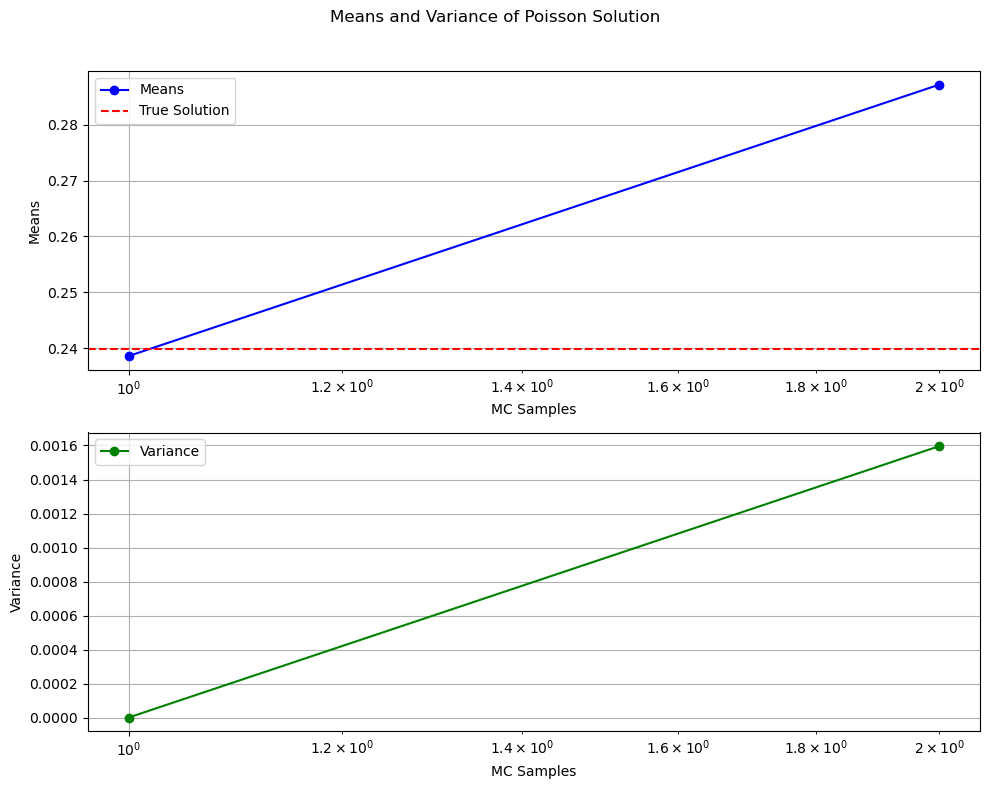

In [44]:
mc_samples_array = [2, 4, 8] # 2:30 per sample with mesh_resolution_solution = 4

P = fe.Point(0.01, 0.01)
mesh_resolution_inverse_mapping = 8
mesh_resolution_solution = 4
mesh_resolution_fem_true_sol = 4

means = []
vars = []

for mc_samples in mc_samples_array:
    u_sols = []
    for i in range(mc_samples):
        print(f"Iteration {i+1}/{mc_samples}")
        xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), randomFieldV.J)
        inverse_mapped_P = inverse_mapping(P, randomFieldV, xi, mesh_resolution_inverse_mapping)
        u_sols.append(solve_poisson_for_given_sample(mesh_resolution_solution, jacobianV, xi, RHS_F)(inverse_mapped_P))
    means.append(np.mean(u_sols))
    vars.append(np.var(u_sols))

true_sol_P = true_sol(mesh_resolution_fem_true_sol)(P)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot means and true solution
ax1.plot(mc_samples_array, means, 'bo', marker='x', linestyle='None', label='Means')
ax1.axhline(y=true_sol_P, color='r', linestyle='--', label='True Solution')
ax1.set_xscale('log')
ax1.set_xlabel('MC Samples')
ax1.set_ylabel('Means')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot variance
ax2.plot(mc_samples_array, vars, 'go', marker='x', linestyle='None', label='Variance')
ax2.set_xscale('log')
ax2.set_xlabel('MC Samples')
ax2.set_ylabel('Variance')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.suptitle('Means and Variance of Poisson Solution')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [52]:
def non_varying_area(len_xi, randomFieldV):   
    R_nv = np.sqrt(3) * np.sqrt((np.sum([np.sqrt(randomFieldV.eigenvalues[m]) * 3 * np.max([np.abs(randomFieldV.eigenvectors[j, m]) for j in range(randomFieldV.N)]) for m in range(len_xi)]))**2 \
                                + (np.sum([np.sqrt(randomFieldV.eigenvalues[m]) * 3 * np.max([np.abs(randomFieldV.eigenvectors[randomFieldV.N + j, m]) for j in range(randomFieldV.N)]) for m in range(len_xi)]))**2)
    print(f"R_nv (maximal perturbation distance): {R_nv}") # maximal perturbation distance

    # Non-Varying Area
    if R_nv >= 1:
            raise ValueError(f"for len(xi): {len(xi)} the non-varying area is the empty set")
    return mshr.Circle(CENTER, 1 - R_nv)

R_nv (maximal perturbation distance): 0.7823762976936882
    Solving linear variational problem.
R_nv (maximal perturbation distance): 0.7823762976936882    Solving linear variational problem.

    *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
    *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
    Solving linear variational problem.
    Solving linear variational problem.
R_nv (maximal perturbation distance): 0.7823762976936882    Solving linear variational problem.

    *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
    *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
    Solving linear variational problem.
    Solving linear variational problem.
    Solving linear variational problem.
    Solving linear variational problem.
R_nv (maximal perturbation distance): 0.7823762976936882    Solving linear variational proble

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_54696/1744160709.py:49: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_54696/1744160709.py:57: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.



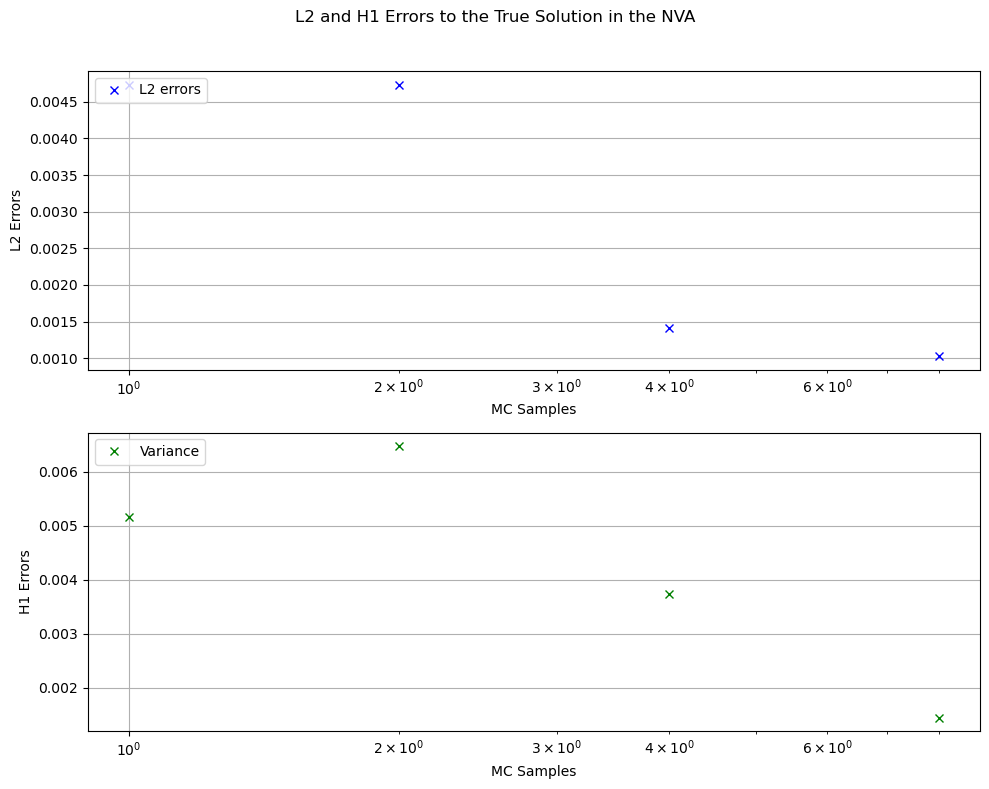

In [62]:
mc_sample_sizes = [1, 2, 4, 8] # with input x, 10, 4, 4 approx. 40 seconds per x
len_xi = 10
mesh_resolution_NVA = 6
mesh_resolution_inverse_mapping = 4
mesh_resolution_solution = 4
mesh_resolution_true_sol = 6

L2_errors = []
H1_errors = []

for mc_sample_size in mc_sample_sizes:
    # Maybe consider pushing out some fixed code of the loop, but for refactoring reasons it is kept here

    xis = [np.random.uniform(-np.sqrt(3), np.sqrt(3), len_xi) for _ in range(mc_sample_size)]

    NVA = non_varying_area(len_xi, randomFieldV)
    mesh_NVA = mshr.generate_mesh(NVA, mesh_resolution_NVA)

    V = fe.FunctionSpace(mesh_NVA, 'P', 1)
    dofmap = V.dofmap()
    dof_coordinates = V.tabulate_dof_coordinates().reshape((-1, mesh_NVA.geometry().dim())) # Those are all the point in mesh_NVA but ordered by the dof which we need to assign by the means

    u_P_NVA_mean = np.zeros(len(dof_coordinates))

    u_sols = []
    for xi in xis:
        u_sols.append(solve_poisson_for_given_sample(mesh_resolution_solution, jacobianV, xi, RHS_F))
        
    for i, P_coords in enumerate(dof_coordinates):
        P = fe.Point(P_coords)
        for xi, u_sol in zip(xis, u_sols):
            P_hat = inverse_mapping(P, randomFieldV, xi, mesh_resolution_inverse_mapping)
            u_P_NVA_mean[i] += u_sol(P_hat) / mc_sample_size

    u_mean = fe.Function(V)
    u_mean.vector()[:] = u_P_NVA_mean

    u_true = true_sol(mesh_resolution_true_sol)
    u_true_interpolated = fe.interpolate(u_true, V)

    L2_errors.append(fe.errornorm(u_true_interpolated, u_mean, norm_type='L2'))
    H1_errors.append(fe.errornorm(u_true_interpolated, u_mean, norm_type='H1'))


# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot means and true solution
ax1.plot(mc_sample_sizes, L2_errors, 'bo', marker='x', linestyle='None', label='L2 errors')
ax1.set_xscale('log')
ax1.set_xlabel('MC Samples')
ax1.set_ylabel('L2 Errors')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot variance
ax2.plot(mc_sample_sizes, H1_errors, 'go', marker='x', linestyle='None', label='H1 Errors')
ax2.set_xscale('log')
ax2.set_xlabel('MC Samples')
ax2.set_ylabel('H1 Errors')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.suptitle('L2 and H1 Errors to the True Solution in the NVA')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()